In [ ]:
%matplotlib inline

In [ ]:
# !pip install dgl
!pip install dgl==0.6.1
!pip install torch==1.9.1
!pip install node2vec

     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 831.4 MB 2.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=62adaab283751a29d92761a54414c4056160c12d461a99ce6fa00ada8acaeec3
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae

In [ ]:
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import dgl.function as fn
import itertools
import numpy as np
import scipy.sparse as sp
import sklearn.metrics
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score,roc_curve

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [ ]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
u, v = g.edges()

In [ ]:
edge_ids = np.arange(g.number_of_edges())
edge_ids = np.random.permutation(edge_ids)
test_size = int(len(edge_ids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[edge_ids[:test_size]], v[edge_ids[:test_size]]
train_pos_u, train_pos_v = u[edge_ids[test_size:]], v[edge_ids[test_size:]]

In [ ]:
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_edge_ids = np.random.choice(len(neg_u), g.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_edge_ids[:test_size]], neg_v[neg_edge_ids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_edge_ids[test_size:]], neg_v[neg_edge_ids[test_size:]]

In [ ]:
train_g = dgl.remove_edges(g, edge_ids[:test_size])

In [ ]:
def get_optimal_threshold(tpr, fpr, thresholds):
  g_means = tpr*(1-fpr)
  max_index = np.argmax(g_means)
  return thresholds[max_index]

In [ ]:
def binarize_scores(scores, labels, optimal_threshold):
  final_preds = []
  for i in range(len(scores)):
    if(scores[i]<=optimal_threshold):
      final_preds.append(0)
    else:
      final_preds.append(1)
  return np.asarray(final_preds)

# Node2Vec embeddings

In [ ]:
train_u,train_v = train_g.edges()

In [ ]:
nx_g = dgl.to_networkx(train_g)
node2vec = Node2Vec(nx_g, dimensions=100, walk_length=20,num_walks=20)

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


In [ ]:
# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

In [ ]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(train_pos_u.tolist()+train_neg_u.tolist(),train_pos_v.tolist()+train_neg_v.tolist())]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
link_data = [1]*len(train_pos_u.tolist())+[0]*len(train_neg_u.tolist())

In [ ]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(np.array(x), link_data, test_size = 0.3, random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [ ]:
predictions_node2vec = lr.predict_proba(xtest)

In [ ]:
auc_score = roc_auc_score(ytest, predictions_node2vec[:,1])
tpr, fpr, thresholds = roc_curve(ytest, predictions_node2vec[:,1])

In [ ]:
optimal_threshold = get_optimal_threshold(tpr, fpr, thresholds)
binarized_preds = binarize_scores(predictions_node2vec[:,1], ytest, optimal_threshold)

In [ ]:
print('AUC', auc_score)
print("accuracy: ",sklearn.metrics.accuracy_score(ytest,binarized_preds))
print("F-measure: ",sklearn.metrics.f1_score(ytest,binarized_preds))
print("Precision: ",sklearn.metrics.precision_score(ytest,binarized_preds) )
print("Recall: ",sklearn.metrics.recall_score(ytest,binarized_preds))

AUC 0.6082141281391448
accuracy:  0.5949490043710539
F-measure:  0.6889220440134278
Precision:  0.7429605792437651
Recall:  0.64221140472879


# GraphSAGE

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            #computing score
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [ ]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores),scores,labels, roc_curve(labels, scores)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch ',e,' loss: ', loss)

In epoch 0, loss: 0.692488968372345
In epoch 5, loss: 0.6108224987983704
In epoch 10, loss: 0.5941360592842102
In epoch 15, loss: 0.5769254565238953
In epoch 20, loss: 0.5597828030586243
In epoch 25, loss: 0.5370103120803833
In epoch 30, loss: 0.5005838871002197
In epoch 35, loss: 0.44389379024505615
In epoch 40, loss: 0.3866122364997864
In epoch 45, loss: 0.3421592116355896
In epoch 50, loss: 0.3133915066719055
In epoch 55, loss: 0.28480133414268494
In epoch 60, loss: 0.25876376032829285
In epoch 65, loss: 0.2369144856929779
In epoch 70, loss: 0.21558541059494019
In epoch 75, loss: 0.19659866392612457
In epoch 80, loss: 0.1779472976922989
In epoch 85, loss: 0.16027536988258362
In epoch 90, loss: 0.14331689476966858
In epoch 95, loss: 0.12703867256641388


In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    auc_score, scores, labels, (tpr, fpr, thresholds) = compute_auc(pos_score, neg_score)
    opt_threshold = get_optimal_threshold(tpr, fpr, thresholds)
    binarized_preds = binarize_scores(scores,labels, opt_threshold)
    print('AUC', auc_score)
    print("accuracy: ",sklearn.metrics.accuracy_score(labels,binarized_preds))
    print("F-measure: ",sklearn.metrics.f1_score(labels,binarized_preds))
    print("Precision: ",sklearn.metrics.precision_score(labels,binarized_preds) )
    print("Recall: ",sklearn.metrics.recall_score(labels,binarized_preds))

AUC 0.8623741605085241
accuracy:  0.7635071090047393
F-measure:  0.757413709285367
Precision:  0.7774451097804391
Recall:  0.738388625592417


# EDA

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
G = nx.Graph()

In [ ]:
# read data
df = pd.read_csv("/content/drive/MyDrive/CS550/cites.csv")
df_paper = pd.read_csv("/content/drive/MyDrive/CS550/paper.csv")

In [ ]:
color_dict = {'Genetic_Algorithms':'green','Reinforcement_Learning':'red','Theory':'teal','Rule_Learning':'blue','Case_Based':'yellow','Probabilistic_Methods':'pink','Neural_Networks':'orange'}
nodes_dict = {}

nodes_list = df_paper.apply(lambda x: [x[0],x[1]],axis=1)
for item in nodes_list:
  nodes_dict[item[0]] = item[1]

In [ ]:
color_map=[]

for node in G:
  color_map.append(color_dict[nodes_dict[node]])

In [ ]:
edges = list(df.apply(lambda x: (x[0],x[1]),axis=1))

In [ ]:
G.add_edges_from(edges)

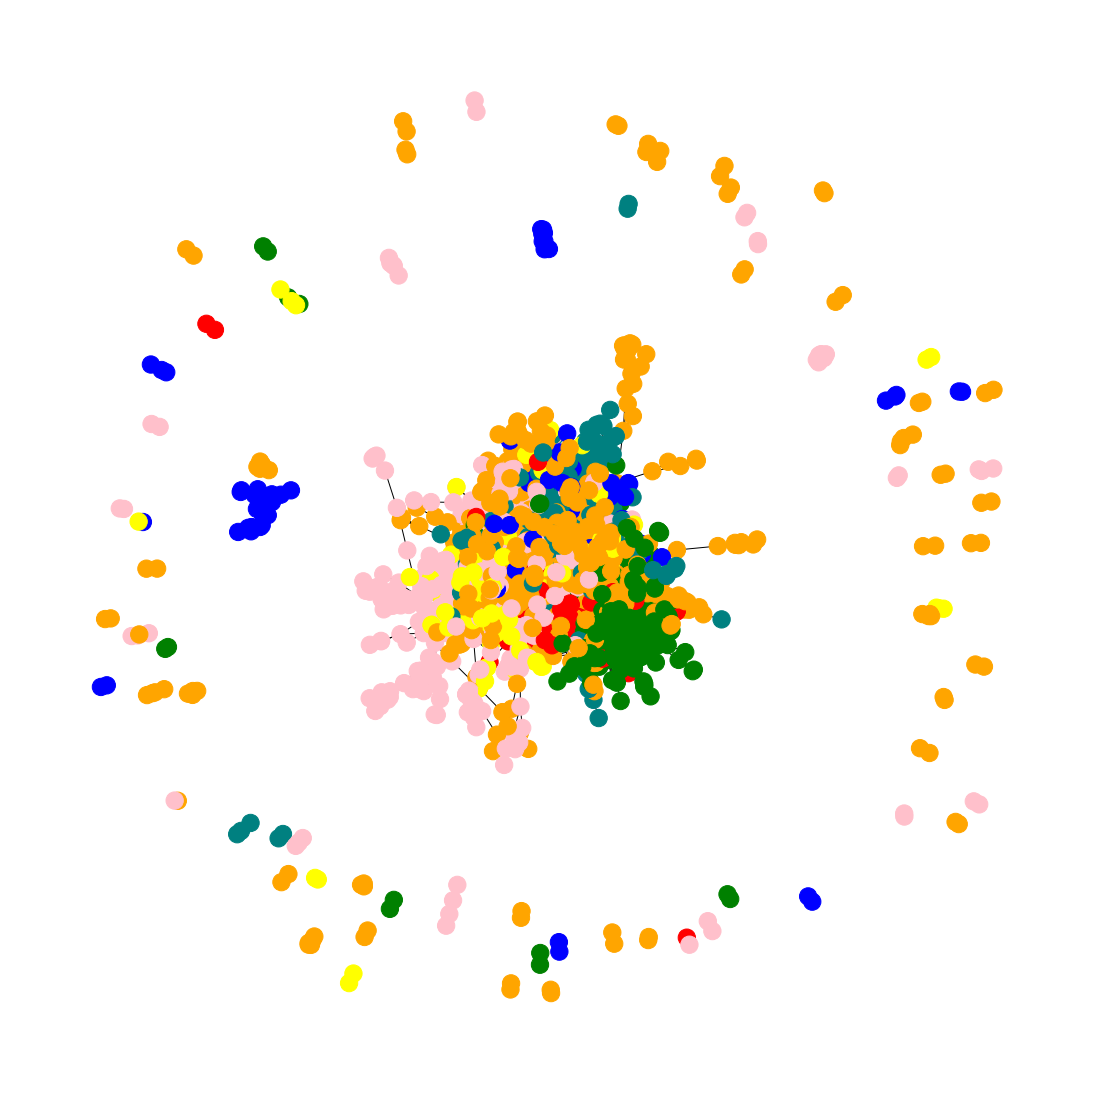

In [ ]:
plt.figure(3,figsize=(15,15))
nx.draw(G, node_color=color_map)
plt.show()

In [ ]:
G.number_of_nodes()

2708

In [ ]:
depths_graph = nx.shortest_path_length(G)
max_clique_size = nx.algorithms.clique.graph_clique_number(G)
max_clique_size

5

In [ ]:
import plotly.express as px

In [ ]:
counts_df = df_paper.groupby('class_label').size().to_frame('count')

In [ ]:
counts_df = counts_df.reset_index()

In [ ]:
fig = px.bar(counts_df, x='class_label', y='count',text_auto='.2s',title="Counts of papers in each class")
fig.show()

In [ ]:
sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]

In [ ]:
for node in sorted_nodes:
  print(node,nodes_dict[node[0]])

(35, 168) Genetic_Algorithms
(6213, 78) Reinforcement_Learning
(1365, 74) Neural_Networks
(3229, 65) Neural_Networks
(910, 44) Neural_Networks


In [ ]:
nx.algorithms.clique.graph_number_of_cliques(G)

3563

In [ ]:
max_cliques = []
for clique in nx.find_cliques(G):
  if len(clique)==5:
     max_cliques.append(clique)

In [ ]:
for max_clique in max_cliques:
  print("clique: ",max_clique)
  for node in max_clique:
    print(node,nodes_dict[node])

clique:  [8224, 22431, 49843, 49844, 49847]
8224 Theory
22431 Rule_Learning
49843 Rule_Learning
49844 Rule_Learning
49847 Rule_Learning
clique:  [1122642, 34257, 34266, 34263, 90655]
1122642 Neural_Networks
34257 Neural_Networks
34266 Neural_Networks
34263 Neural_Networks
90655 Neural_Networks
clique:  [1123188, 6910, 12638, 12631, 662416]
1123188 Neural_Networks
6910 Neural_Networks
12638 Neural_Networks
12631 Neural_Networks
662416 Probabilistic_Methods
clique:  [1123188, 6910, 12638, 12631, 6898]
1123188 Neural_Networks
6910 Neural_Networks
12638 Neural_Networks
12631 Neural_Networks
6898 Neural_Networks
clique:  [124064, 6213, 6224, 6163, 6220]
124064 Reinforcement_Learning
6213 Reinforcement_Learning
6224 Reinforcement_Learning
6163 Reinforcement_Learning
6220 Reinforcement_Learning
clique:  [10435, 1103394, 22563, 22564, 22566]
10435 Case_Based
1103394 Case_Based
22563 Neural_Networks
22564 Case_Based
22566 Case_Based
clique:  [10531, 31353, 686532, 31349, 31336]
10531 Neural_Net

In [ ]:
len(max_cliques)

9

In [ ]:
paper_cites_counts = df.groupby('cited_paper_id').size().to_frame('degree').reset_index()

In [ ]:
def add_degree(row):
  global paper_cites_counts
  # print(row['paper_id'])
  degree_list = paper_cites_counts.loc[paper_cites_counts['cited_paper_id']==row['paper_id'],'degree'].tolist()
  if len(degree_list) != 1:
    return 0
  return degree_list[0]

In [ ]:
df_paper['degree'] = 0

In [ ]:
df_paper['degree'] = df_paper.apply(add_degree, axis=1)

In [ ]:
df_paper.to_csv("/content/drive/MyDrive/CS550/paper_with_degree.csv",index=False)

In [ ]:
len(paper_cites_counts['cited_paper_id'].unique())

1565

In [ ]:
len(df['citing_paper_id'].unique())

2222